In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# '-1': CPUに切り替え
# '0' : index 0 のGPUを使う
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import random

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

torch.manual_seed(0)

In [2]:
# GPU を使用可能か
torch.cuda.is_available()
# PyTorchで使用できるGPUの数
print(torch.cuda.device_count())
# デフォルトのGPU番号（インデックス）
print(torch.cuda.current_device())
# GPU名称
# 引数を省略した場合は、デフォルト（torch.cuda.current_device()が返すインデックス）のGPU
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_name('cuda:0'))
# CUDAが使用するGPUを設定: 環境変数CUDA_VISIBLE_DEVICES
# CUDA_VISIBLE_DEVICESを0とすると0番のGPUのみ、0, 2とすると0番と2番のGPUのみが使用される。-1とするとすべてのGPUが使用されなくなる。

1
0
NVIDIA GeForce RTX 3060
NVIDIA GeForce RTX 3060
NVIDIA GeForce RTX 3060


In [3]:
# Excelなどが使えずcsvファイルのインデックス列を削除できていない場合
# os.mkdir("C:/Users/Mitsu/Desktop/AISTATS/230923/")
os.chdir("C:/Users/Mitsu/Desktop/AISTATS/230929_02/")

## スケーラビリティ実験

In [4]:
# 標準化すると正解率が上がった
def MinMaxNormalizer(q):
    return (q - torch.mean(q))/(torch.std(q))

def MinMaxTensorNormalizer(train_gen):
    tmp = torch.zeros(train_gen.shape)
    for i in range(train_gen.shape[1]):
        tmp[:,i] = MinMaxNormalizer(train_gen[:,i])
    return tmp

In [5]:
def input_data(filename):
    tmp = pd.read_csv(filename, sep=",", encoding="utf-8")
    del tmp["Unnamed: 0"]
    return tmp

def MakeData(num_of_var):
    train_gen = input_data(filename="sample_data_"+str(num_of_var)+"_train_gen.csv")
    train_dis = input_data(filename="sample_data_"+str(num_of_var)+"_train_dis.csv")
    test_gen = input_data(filename="sample_data_"+str(num_of_var)+"_test_gen.csv")
    test_dis = input_data(filename="sample_data_"+str(num_of_var)+"_test_dis.csv")
    # plt.plot(np.linspace(0,len(test_gen[0:100])+1, len(test_gen[0:100])), test_gen.values[0:100])
    # plt.show()
    train_gen = torch.from_numpy(train_gen.values.astype(np.float32)).float()
    train_dis = torch.from_numpy(train_dis.values.astype(np.float32)).float()
    test_gen = torch.from_numpy(test_gen.values.astype(np.float32)).float()
    test_dis = torch.from_numpy(test_dis.values.astype(np.float32)).float()
    # print(train_gen.shape, train_dis.shape, test_gen.shape, test_dis.shape)
    
    train_gen = MinMaxTensorNormalizer(train_gen)
    train_dis = MinMaxTensorNormalizer(train_dis)
    test_gen = MinMaxTensorNormalizer(test_gen)
    test_dis = MinMaxTensorNormalizer(test_dis)
    
    return train_gen, train_dis, test_gen, test_dis

In [6]:
def notears(W, output_dimension): # W は正方行列で要素は整数ではなく実数。整数だとエラー。
    B = torch.mul(W,W)
    matrix_exponential = torch.matrix_exp(B) 
    tmp = torch.trace(matrix_exponential) - output_dimension
    return tmp

In [7]:
def Matrix_decomposition(mat2, output_dimension): # output_dimensionは変数の数
    ##### SEM ###################
    tmp = mat2
    tmp_n = output_dimension 
    tmp2 = tmp[0 : tmp_n] # B0 (contemp matrix)
    tmp2 = torch.triu(tmp2, diagonal = 1) # B0を無理やり上三角行列にするやり方
    tmp3 = tmp[tmp_n : tmp_n * 2] # B1
    tmp4 = tmp[tmp_n * 2 : tmp_n * 3] # Error matrix
    tmp4 = torch.diag(torch.diag(tmp4))
    tmp5 = torch.cat((tmp2, tmp3, tmp4)) # 結局B0,B1には何もしないでエラーだけ対角行列にした行列
    return tmp5

   #### ODE ###############
#     tmp = mat2
#     tmp_n = output_dimension 
#     var = int((mat2.shape[0] - tmp_n)/2) # number of linear + nonlinear variables
#     tmp2 = tmp[0 : tmp_n] # B0 (contemp matrix)
#     tmp2 = torch.triu(tmp2, diagonal = 1) # B0を無理やり上三角行列にするやり方
#     tmp3 = tmp[tmp_n : var * 2] # B0(nonlinear) + B1
#     tmp4 = tmp[var * 2 : var * 2 + tmp_n] # Error matrix
#     tmp4 = torch.diag(torch.diag(tmp4))
#     tmp5 = torch.cat((tmp2, tmp3, tmp4)) # 結局B0,B1には何もしないでエラーだけ対角行列にした行列
#     return tmp5

In [8]:
# def ConditionalLabel(which_variable_generate):
def ConditionalLabelGenerator(which_variable_generate, Time, output_dimension):
    if which_variable_generate == 0:
        noise_vector_label = torch.ones(Time, 1)
    else:
        noise_vector_label = torch.zeros(Time, 1)

    tmp_zeros = torch.zeros(Time, 1)
    tmp_ones = torch.ones(Time, 1)
    for i in range(1, output_dimension):
        if i == which_variable_generate:
            noise_vector_label = torch.cat((noise_vector_label, tmp_ones),dim=0)
        else:
            noise_vector_label = torch.cat((noise_vector_label, tmp_zeros),dim=0)
            
    return noise_vector_label # ノイズベクトルにつけたのと同じような変数選択のラベルを、正解データに付与するための関数

In [9]:
def MatrixConstraint(tmp):
    tmp = tmp.reshape(output_dimension,input_dimension).T
    return Matrix_decomposition(tmp, output_dimension).T.reshape(output_dimension*input_dimension,1)

In [10]:
def Which_variable_list(iteration, output_dimension):
    tmp = []
    for i in range(iteration):
        tmp.append(i % output_dimension)

    return tmp

In [23]:
def Measurements(coeff_pred, coeff_truth):
    TP,TN,FP,FN=0,0,0,0
    for i in range(coeff_pred.shape[0]):
        for j in range(coeff_pred.shape[1]):
            if coeff_pred[i][j] == coeff_truth[i][j]:
                if coeff_pred[i][j].data.numpy()==1.0:
                    # print("True positive", coeff_pred[i][j])
                    TP += 1
                elif coeff_pred[i][j].data.numpy()==0.0:
                    # print("True negative", coeff_pred[i][j])
                    TN += 1
            else:
                if coeff_pred[i][j].data.numpy()==1.0:
                    # print("False positive", coeff_pred[i][j])
                    FP += 1
                elif coeff_pred[i][j].data.numpy()==0.0:
                    # print("False negative", coeff_pred[i][j])
                    FN += 1

    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP+FN)
    F1 = TP / (TP + 1/2 * (FP + FN))
    MyScore = 1 / ( 1 + (FP + FN) )
    MyScore2 = (FP + FN)  / (TP + FP + FN + TN)
#     print("Accuracy:",Accuracy)
#     print("Precision:",Precision)
#     print("Recall:",Recall)
#     print("F-measure:",F1)
    return Accuracy, Precision, Recall, F1, MyScore, MyScore2

In [12]:
def DTW_Mean(DTW_dict_list):
    DTW_mean_list = []
    for DTW_dict_arg in DTW_dict_list:
        h=0
        tmp = []
        for i in range(len(DTW_dict_arg)):
            if i%2 == 0:
                tmp.append(DTW_dict_arg["x"+str(h)+"_mean"])
                h+=1
        DTW_mean_list.append(sum(tmp)/len(tmp))
    return DTW_mean_list

In [718]:
# 結果にあまり影響なし：outer_iteration, iteration, lr
# 結果に影響：L1/L2/baseline, lambda_notears, lambda_regularizer # NO TEARS 0.1, Regularization 0.1 だと比較的ましになった
# 時系列データによっても予測性能が異なる。すぐに収束していてほとんど平衡状態の曲線だと掴みにくい（？）
# 時系列データがODEsだと、つまり自身の t-1 の時点からの因果効果（係数）が１だと、うまくいく（？）
# Error項のスケールと、係数行列のスケールは同じにする。たとえばError termを大きくしてしまうと、同じデータ点に対して時系列データの占める割合が減ってしまう。
# Error term があまりに小さいとError項を無視してしまう。

num of var: 2
== outer iteration == 0 / 20
== outer iteration == 5 / 20
== outer iteration == 10 / 20
== outer iteration == 15 / 20
num of var: 3
== outer iteration == 0 / 30
== outer iteration == 5 / 30
== outer iteration == 10 / 30
== outer iteration == 15 / 30
== outer iteration == 20 / 30
== outer iteration == 25 / 30
num of var: 4
== outer iteration == 0 / 40
== outer iteration == 5 / 40
== outer iteration == 10 / 40
== outer iteration == 15 / 40
== outer iteration == 20 / 40
== outer iteration == 25 / 40
== outer iteration == 30 / 40
== outer iteration == 35 / 40
num of var: 5
== outer iteration == 0 / 50
== outer iteration == 5 / 50
== outer iteration == 10 / 50
== outer iteration == 15 / 50
== outer iteration == 20 / 50
== outer iteration == 25 / 50
== outer iteration == 30 / 50
== outer iteration == 35 / 50
== outer iteration == 40 / 50
== outer iteration == 45 / 50
num of var: 6
== outer iteration == 0 / 60
== outer iteration == 5 / 60
== outer iteration == 10 / 60
== outer i

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


L2 DONE.
num of var: 2
== outer iteration == 0 / 20
== outer iteration == 5 / 20
== outer iteration == 10 / 20
== outer iteration == 15 / 20
num of var: 3
== outer iteration == 0 / 30
== outer iteration == 5 / 30
== outer iteration == 10 / 30
== outer iteration == 15 / 30
== outer iteration == 20 / 30
== outer iteration == 25 / 30
num of var: 4
== outer iteration == 0 / 40
== outer iteration == 5 / 40
== outer iteration == 10 / 40
== outer iteration == 15 / 40
== outer iteration == 20 / 40
== outer iteration == 25 / 40
== outer iteration == 30 / 40
== outer iteration == 35 / 40
num of var: 5
== outer iteration == 0 / 50
== outer iteration == 5 / 50
== outer iteration == 10 / 50
== outer iteration == 15 / 50
== outer iteration == 20 / 50
== outer iteration == 25 / 50
== outer iteration == 30 / 50
== outer iteration == 35 / 50
== outer iteration == 40 / 50
== outer iteration == 45 / 50
num of var: 6
== outer iteration == 0 / 60
== outer iteration == 5 / 60
== outer iteration == 10 / 60
=

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ablation DONE.


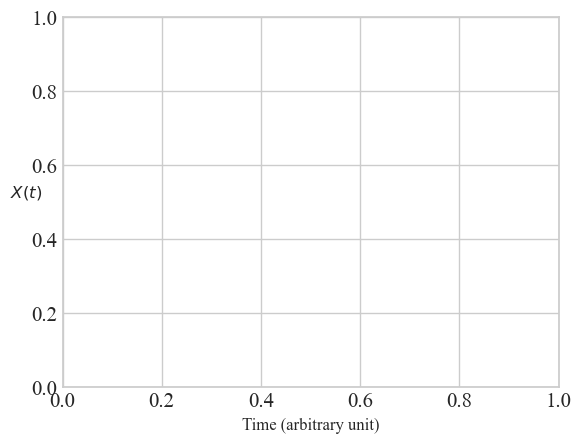

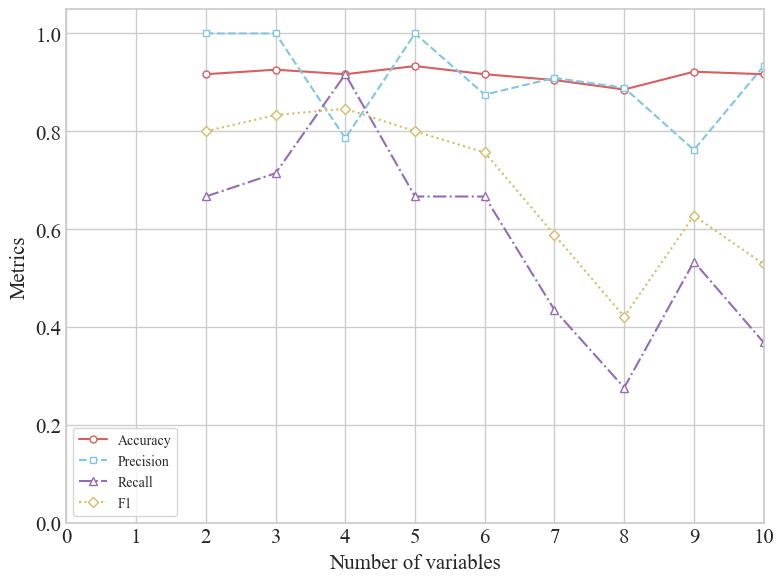

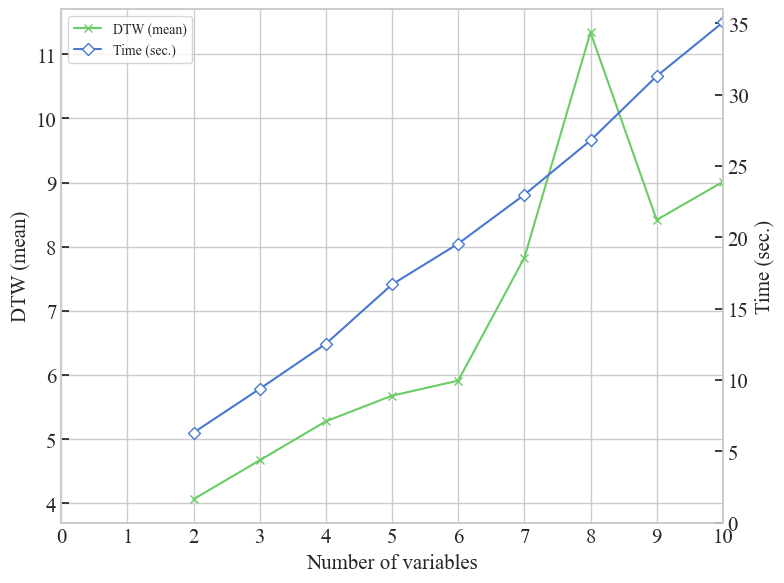

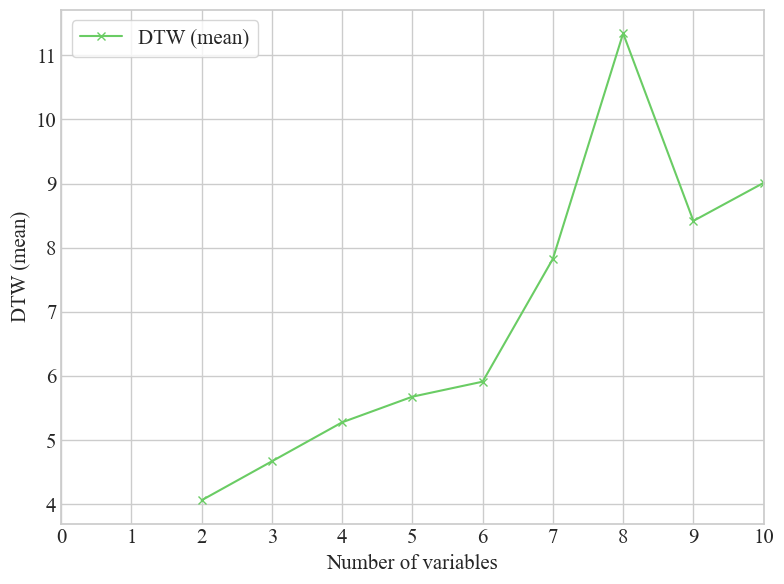

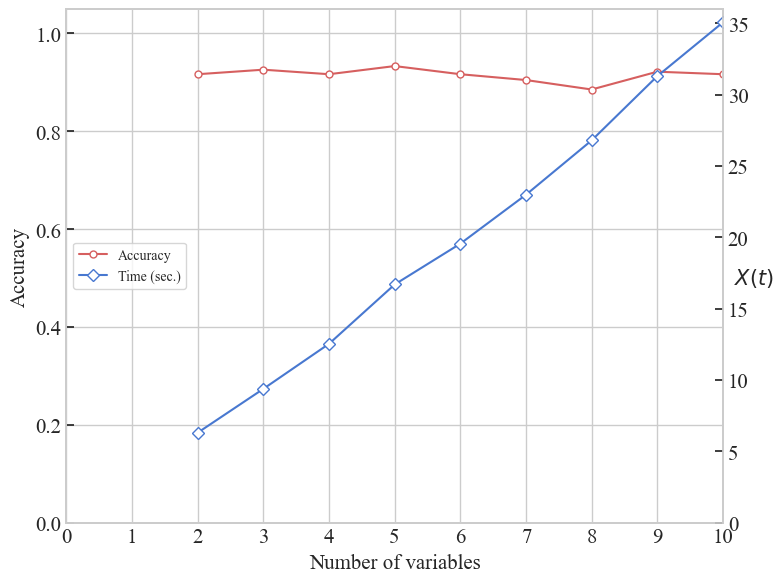

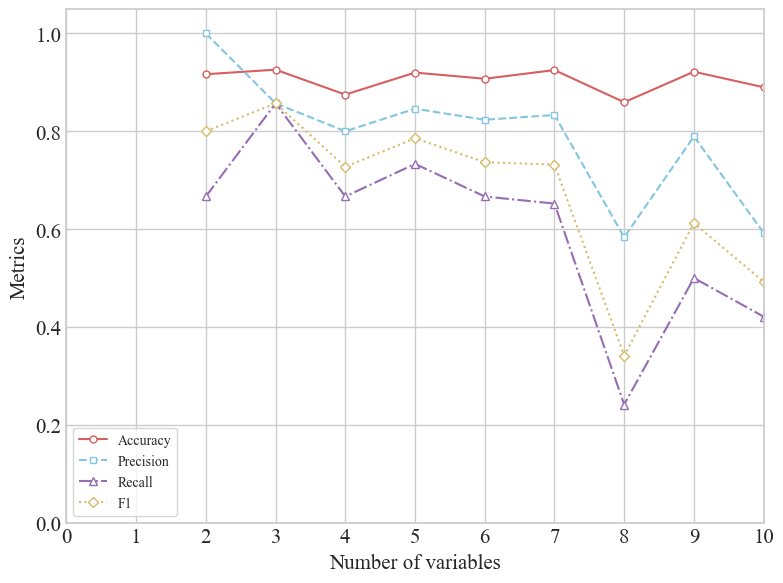

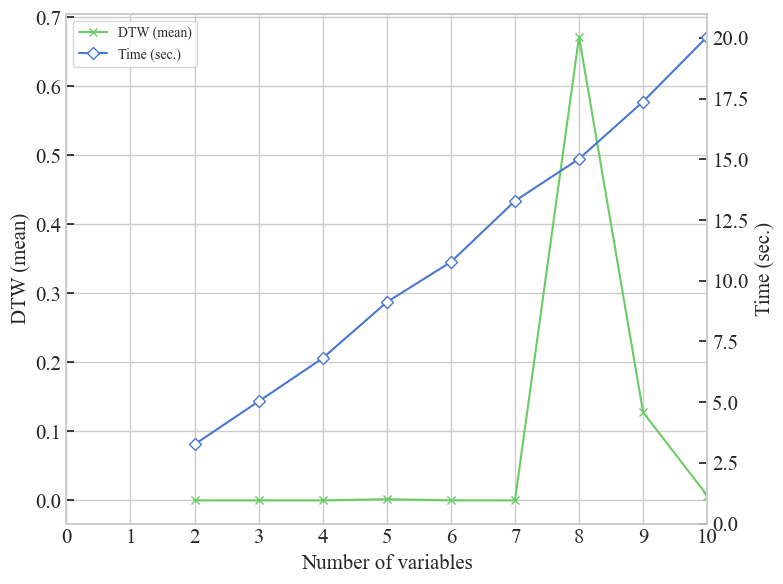

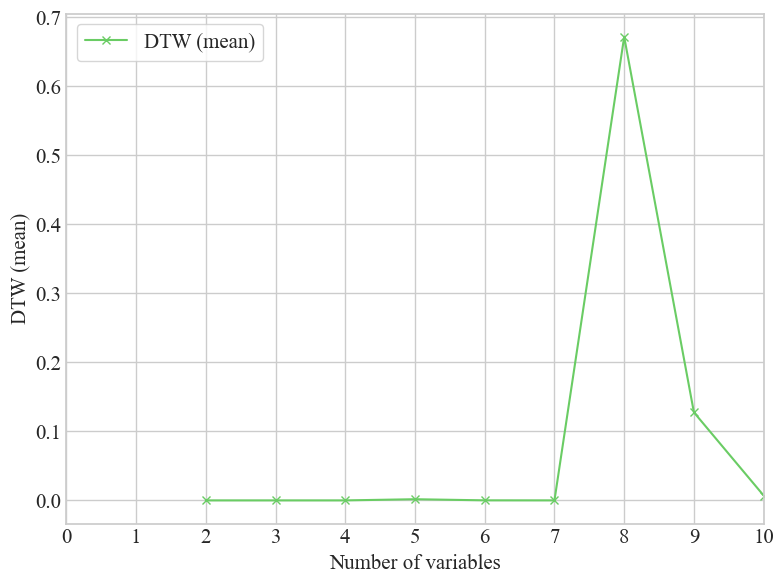

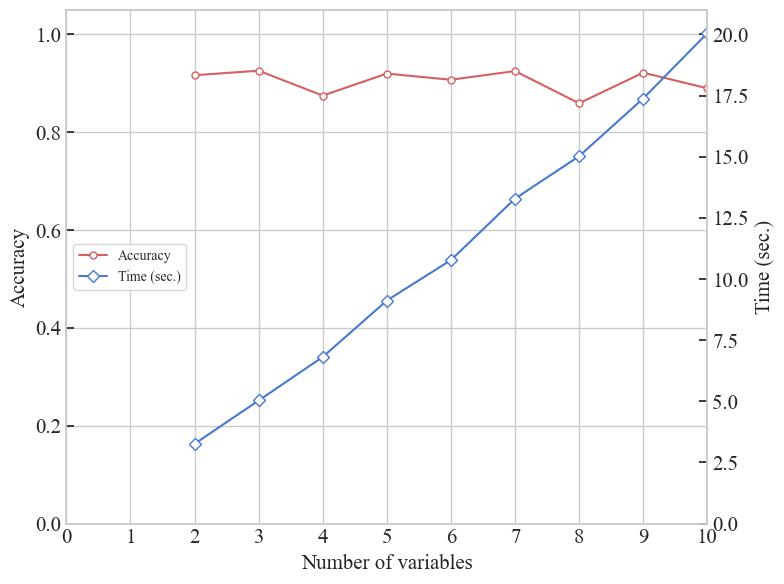

In [31]:
method_list = ["L2", "ablation"]
Max_num_of_var = 10
for method in method_list:
    os.mkdir(method)
    # Input: Time x coefficient matrix column number (in_features)
    # Output: Time x output_dimension
    # generator(Input, output_dimension)
    Accuracy_dict, Precision_dict, Recall_dict, F1_dict, MyScore_dict, MyScore2_dict = dict(), dict(), dict(), dict(), dict(), dict()
    Time_dict = dict()
    DTW_dict_dict = dict()
    Coeff_result_mean_dict, Coeff_result_std_dict, Coeff_result_probability_dict = dict(), dict(), dict()
    for outer_outer_iteration in range(2,Max_num_of_var+1):
        num_of_var = outer_outer_iteration
        print("num of var:",num_of_var)

        train_gen, train_dis, test_gen, test_dis = MakeData(num_of_var)
        # class Generator より上で定義
        outer_iteration = 10 * num_of_var
        output_dimension = train_dis.shape[1] # number of variables
        which_variable_generate = 0 # x0: 0, x1: 1, x2: 2, ...
        Time = train_dis.shape[0]

        ##### SEM ##########
        input_dimension = output_dimension * 3 # coefficient matrix's row
        #### ODE (or Nonlinear SEM) ############
        # input_dimension = train_gen.shape[1] # coefficient matrix's row

        class Generator(torch.nn.Module):
            def __init__(self):
                super(Generator, self).__init__()
                self.linear1 = torch.nn.Linear(in_features = input_dimension, out_features=output_dimension, bias=False) # output: (noise_frequency * 2) x output_features
                torch.nn.init.uniform_(self.linear1.weight, a=0.5, b=1.0)

            def forward(self, x, output_dimension, input_dimension, which_variable_generate, Time):
                x = self.linear1(x)

                return x

        generator = Generator()

        # print(generator)
        # print(generator.linear1.weight.T)

        # Sample 
        # Time = 10
        # tmp1 = torch.randn(Time, input_dimension)
        # Affine = generator(tmp1,  output_dimension, input_dimension, which_variable_generate, Time)
        # print("NNへの入力シグマ：", tmp1)
        # print("NNの出力（データ）：", Affine)
        # print("重み（係数）行列（グザイ予測値）: ",generator.linear1.weight.T)
        # たしかに、tmp （入力）に、重み num_of_var (output_dimension) x coeff matrix row の転値を行列積すると出力Affineになる。
        ##############################################################################################################################

        lr = 0.01
    #     iteration = 1000
        iteration = 500
        lambda_notears = 0.01
        lambda_regularizer = 0.01
        regularization_setting = method # "baseline", "L1", "L2"
        notears_penalty_setting = "with no tears" # "with no tears", "without no tears"
        if method == "ablation":
            regularization_setting = "baseline" # "baseline", "L1", "L2"
            notears_penalty_setting = "without no tears" # "with no tears", "without no tears"

        Generator_loss = torch.nn.MSELoss()

        weight_parameter_coeff_matrix_list = []
        which_variable_generate_list = Which_variable_list(iteration, output_dimension)
        generator_losses = []
        time_sta = time.perf_counter()
        coeff_matrix_row_number = train_gen.shape[1]
        
        NN_weight_dict = dict()
        for nn in range(output_dimension):
            NN_weight_dict["x"+str(nn)] = generator.linear1.weight
        
        for outer_iteration_arg in range(outer_iteration):
            which_variable_generate = which_variable_generate_list[outer_iteration_arg]
            
            generator.linear1.weight = NN_weight_dict["x"+str(which_variable_generate)]
            
            tmp = torch.mul(generator.linear1.weight.T.reshape(input_dimension * output_dimension, 1), 
            MatrixConstraint(ConditionalLabelGenerator(which_variable_generate, input_dimension, output_dimension)))
                # generator.linear1.weight: 2 x 6  --Transpose--> 6 x 2 --reshape--> 12 x 1
            weight_new = torch.nn.Parameter(tmp.reshape(output_dimension, input_dimension)) # tmp 12 x 1 --reshape--> 2 x 6
            generator.linear1.weight = weight_new
            
            generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
            
            for i in range(iteration):
                
                generator_optimizer.zero_grad()  

                train_dis_reshaped = train_dis.T.reshape(train_dis.shape[0] * output_dimension, 1)
                train_dis_reshaped = torch.mul(train_dis_reshaped,
                                    ConditionalLabelGenerator(which_variable_generate, train_dis.shape[0], output_dimension))

                Affine = generator(train_gen,  output_dimension, input_dimension, which_variable_generate, Time)

                generator_loss = Generator_loss(Affine, train_dis) # 損失を計算(shapeを揃える)

                coeff_matrix = generator.linear1.weight.T

                if regularization_setting == "baseline":
                    pass
                elif regularization_setting == "L1":
                    generator_loss += lambda_regularizer * torch.linalg.matrix_norm(coeff_matrix, ord=1)        # 損失を計算(shapeを揃える)
                elif regularization_setting == "L2":
                    generator_loss += lambda_regularizer * torch.norm(coeff_matrix, p="fro")     # 損失を計算(shapeを揃える)
                else:
                    print("Regularization setting expects 'baseline', 'L1', or 'L2' only.")
                    break

                mat3 = coeff_matrix[0 : output_dimension]

                if notears_penalty_setting == "with no tears": # "with no tears", "without no tears"
                    half_iteration = int(iteration/2)
                    if i <= half_iteration:
                        pass
                    else:
                        generator_loss += (lambda_notears + lambda_notears * (i-half_iteration)/half_iteration) * notears(mat3, output_dimension)
                elif notears_penalty_setting == "without no tears":
                    pass
                else:
                    print("NO TEARS penalty setting expects 'with no tears', 'without no tears' only.")
                    break

                generator_optimizer.zero_grad()
                generator_loss.backward()
                generator_optimizer.step()
                generator_losses.append(generator_loss.item())  
        #         if i % 500 == 0:
        #             print(i,"/",iteration)
            
            NN_weight_dict["x"+str(nn)] = generator.linear1.weight
            
            weight_parameter_coeff_matrix = generator.linear1.weight.T
            weight_parameter_coeff_matrix_list.append(weight_parameter_coeff_matrix)
            if outer_iteration_arg % 5 == 0:
                print("== outer iteration ==", str(outer_iteration_arg),"/",str(outer_iteration))

        time_end = time.perf_counter()
        tim = time_end- time_sta
        Time_dict["x"+str(num_of_var)] = tim #  / outer_iteration

        #########################################################################################################################
        # 係数行列の平均値 (biasは１ではない)
        tmp = torch.zeros(input_dimension, output_dimension)
        for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
            tmp += weight_parameter_coeff_matrix

        result_mean = tmp/outer_iteration
        Coeff_result_mean_dict["x"+str(num_of_var)] = result_mean

        # 係数行列の標準誤差
        tmp = torch.zeros(input_dimension, output_dimension)
        for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
            var = torch.square(weight_parameter_coeff_matrix - result_mean)
            tmp += var

        result_std = torch.sqrt(tmp/(outer_iteration-1))
        Coeff_result_std_dict["x"+str(num_of_var)] = result_std

        # DTW: Stan Salvador, and Philip Chan. “FastDTW: Toward accurate dynamic time warping in linear time and space.” Intelligent Data Analysis 11.5 (2007): 561-580.

        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
        plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
        plt.rcParams["font.size"] = 10                 # 文字の大きさ
        plt.tick_params(labelsize = 15) 
        plt.xlabel("Time (arbitrary unit)")
        plt.ylabel(r"$X(t)$",rotation=0)

        DTW_dict = dict()
        for i in range(num_of_var):
            DTW_x0_list = []
            for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
                mat2 = weight_parameter_coeff_matrix

                Affine = generator(test_gen,  output_dimension, input_dimension, which_variable_generate=i, Time=test_gen.shape[0])
                pred_x0 = Affine.data.numpy()[:,i]
                truth_x0 = test_dis.data.numpy()[:,i]

                distance, path = fastdtw(pred_x0.reshape(-1, 1), truth_x0.reshape(-1,1), dist=euclidean)
                DTW_x0_list.append(distance)

            DTW_dict["x"+str(i)+"_mean"] = np.mean(DTW_x0_list)
            DTW_dict["x"+str(i)+"_std"] = np.std(DTW_x0_list)

            # 動的挙動
            width = int(len(pred_x0))
            # plt.plot(np.linspace(0,width-1,width),pred_x0[0:width], label=r"pred_$x_{"+str(i)+"}(t)$") # ここで時間がかかっているらしい
            # plt.plot(np.linspace(0,width-1,width),truth_x0[0:width],linewidth=0.7, label=r"truth_$x_{"+str(i)+"}(t)$") # ここで時間がかかっているらしい

        DTW_dict_dict["x"+str(num_of_var)] = DTW_dict
        # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # plt.tight_layout() 
        # plt.savefig(method+"/sample_data_"+str(num_of_var)+"_prediction.svg")
        # plt.savefig(method+"/sample_data_"+str(num_of_var)+"_prediction.png")
        # plt.show()

        # # plt.plot(np.linspace(0, iteration*outer_iteration-1, iteration*outer_iteration), generator_losses, label="gen loss + additional terms")
        # plt.plot(np.linspace(0, iteration-1, iteration), generator_losses[0:iteration], label="gen loss + additional terms")
        # plt.show()

        # Probability
        # 絶対値がthreshold を超えるか判定
        threshold_value_candidate = 1000
        width = torch.max(torch.abs(weight_parameter_coeff_matrix)) - torch.min(torch.abs(weight_parameter_coeff_matrix))
        alice = pd.DataFrame({})
        for hh in range(threshold_value_candidate):
            threshold = torch.min(torch.abs(weight_parameter_coeff_matrix)) + width * hh / threshold_value_candidate # This threshold value is very important
            thresholding_list = []
            for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
                # torch.where(torch.abs(weight_parameter_coeff_matrix) <= threshold, torch.tensor(0.0), weight_parameter_coeff_matrix)
                tmp = torch.where(torch.abs(weight_parameter_coeff_matrix) <= threshold, torch.tensor(0.0), torch.ones(weight_parameter_coeff_matrix.shape))
                thresholding_list.append(tmp)

            tmp = torch.zeros(input_dimension, output_dimension)
            for i in thresholding_list:
                tmp += i

            coeff_pred = tmp/outer_iteration
            coeff_truth = pd.read_csv("sample_data_"+str(num_of_var)+".csv", sep=",", encoding="utf-8")
            del coeff_truth["Unnamed: 0"]
            coeff_truth = torch.from_numpy(coeff_truth.values.astype(np.float32)).float()
            # threshold はpredもtruthもそろえた方がいいのでは？
            threshold = 0.0001 # This is Okay (This is for discretizing truth coeff matrix)

            coeff_pred = torch.where(torch.abs(coeff_pred) <= threshold, torch.tensor(0.0), torch.ones(coeff_pred.shape))
            coeff_truth = torch.where(torch.abs(coeff_truth) <= threshold, torch.tensor(0.0), torch.ones(coeff_truth.shape))
            tmp = torch.ones(output_dimension)
            tmp = torch.diag(tmp)
            coeff_truth = torch.cat((coeff_truth,tmp))

            Accuracy, Precision, Recall, F1, MyScore, MyScore2 = Measurements(coeff_pred, coeff_truth)
            hoge = Accuracy + Precision + Recall + F1 + MyScore
            hoge2 = pd.DataFrame({"hh":[hh], "hoge": [hoge], "Acc": [Accuracy], "Prec": [Precision], "Recall": [Recall], "F1": [F1], "MyScore":[MyScore], "MyScore2": [MyScore2] })
            alice = pd.concat([alice, hoge2])

        alice = alice.sort_values(['MyScore', 'F1', 'Acc', 'hoge', 'Prec', 'Recall'], ascending=False) # この順番でかなり結果が変わる F1 を前の方にする。
        tmp2 = alice.head(n=1)

        hh = tmp2["hh"][0]
        threshold = width * hh / threshold_value_candidate # This threshold value is very important
        thresholding_list = []
        for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
            tmp = torch.where(torch.abs(weight_parameter_coeff_matrix) <= threshold, torch.tensor(0.0), torch.ones(weight_parameter_coeff_matrix.shape))
            thresholding_list.append(tmp)
        tmp = torch.zeros(input_dimension, output_dimension)
        for i in thresholding_list:
            tmp += i
        coeff_pred = tmp/outer_iteration
        Coeff_result_probability_dict["x"+str(num_of_var)] = coeff_pred

        Accuracy = tmp2["Acc"][0]
        Precision = tmp2["Prec"][0]
        Recall = tmp2["Recall"][0]
        F1 = tmp2["F1"][0]
        MyScore = tmp2["MyScore"][0]
        MyScore2 = tmp2["MyScore2"][0]

        Accuracy_dict["x"+str(num_of_var)] = Accuracy
        Precision_dict["x"+str(num_of_var)] = Precision
        Recall_dict["x"+str(num_of_var)] = Recall
        F1_dict["x"+str(num_of_var)] = F1
        MyScore_dict["x"+str(num_of_var)] = MyScore
        MyScore2_dict["x"+str(num_of_var)] = MyScore2

    print("DONE")
    ###############################################################################################################################################
    # Accuracy_dict, Precision_dict, Recall_dict, F1_dict
    # MyScore_dict
    # Time_dict, DTW_dict_dict
    # Coeff_result_mean_dict, Coeff_result_std_dict, Coeff_result_probability_dict, coeff_truth

    Num_of_var_list = []
    Time_list, DTW_dict_list = [], []
    Accuracy_list, Precision_list, Recall_list, F1_list, MyScore_list, MyScore2_list = [],[],[],[], [], []
    Coeff_result_mean_list, Coeff_result_std_list, Coeff_result_probability_list = [],[],[]

    for i in range(2,Max_num_of_var+1):
        Num_of_var_list.append(i)
        Accuracy_list.append(Accuracy_dict["x"+str(i)])
        Precision_list.append(Precision_dict["x"+str(i)])
        Recall_list.append(Recall_dict["x"+str(i)])
        F1_list.append(F1_dict["x"+str(i)])
        MyScore_list.append(MyScore_dict["x"+str(i)])
        MyScore2_list.append(MyScore2_dict["x"+str(i)])
        Time_list.append(Time_dict["x"+str(i)])
        DTW_dict_list.append(DTW_dict_dict["x"+str(i)])
        Coeff_result_mean_list.append(Coeff_result_mean_dict["x"+str(i)].data.numpy())
        Coeff_result_std_list.append(Coeff_result_std_dict["x"+str(i)].data.numpy())
        Coeff_result_probability_list.append(Coeff_result_probability_dict["x"+str(i)].data.numpy())

    DTW_mean_list = DTW_Mean(DTW_dict_list)

    df6 = pd.DataFrame({
        "Num_of_var": Num_of_var_list,
        "Accuracy": Accuracy_list,
        "Precision": Precision_list,
        "Recall": Recall_list,
        "F1": F1_list,
        "Error rate": MyScore2_list, # 1 - Accuracy （全要素中、何割間違えたか）
        "1/(1+FP+FN)": MyScore_list,
        "Time": Time_list,
        "DTW": DTW_dict_list,
        "DTW_mean": DTW_mean_list,
        "Coeff_result_mean": Coeff_result_mean_list,
        "Coeff_result_std": Coeff_result_std_list,
        "Coeff_result_probability": Coeff_result_probability_list
    })

    df6.to_csv(method+"/Results.csv", sep=",", encoding="utf-8")
    ########################################################################################################################

    # colormapをカスタマイズする
    from matplotlib.colors import LinearSegmentedColormap
    import math

    def generate_cmap(colors):
        """自分で定義したカラーマップを返す"""
        values = range(len(colors))

        vmax = np.ceil(np.max(values))
        color_list = []
        for v, c in zip(values, colors):
            color_list.append( ( v/ vmax, c) )
        return LinearSegmentedColormap.from_list('custom_cmap', color_list)

    from matplotlib import cm
    from matplotlib.ticker import MaxNLocator
    import seaborn as sns
    sns.set(style="whitegrid", palette="muted", color_codes=True) 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
    plt.rcParams["font.size"] = 12                # 文字の大きさ
    plt.tick_params(labelsize = 15) 
    # cm = plt.get_cmap("Spectral")

    fig, ax1 = plt.subplots(figsize=(8, 6),tight_layout=True)
    # ax2 = ax1.twinx()
    # 2軸グラフの本体設定
    ax1.plot(df6["Num_of_var"], df6["Accuracy"],
            color = 'r', label="Accuracy", linewidth=1.5, linestyle="-", marker='o', markersize=5, markerfacecolor="w") # color = cm(1/3) cm.Set2.colors[0]
    ax1.plot(df6["Num_of_var"], df6["Precision"],
            color = 'c', label="Precision", linewidth=1.5, linestyle="--", marker='s', markersize=5, markerfacecolor="w")
    ax1.plot(df6["Num_of_var"], df6["Recall"],
            color = 'm', label="Recall", linewidth=1.5, linestyle="-.", marker='^', markersize=6, markerfacecolor="w")
    ax1.plot(df6["Num_of_var"], df6["F1"],
            color = 'y', label="F1", linewidth=1.5, linestyle="dotted", marker='D', markersize=5, markerfacecolor="w")

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # 目盛りを整数にする
    # ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax1.set_xticks(np.linspace(2,len(df6)+1,len(df6)-2+1+1))

    plt.tick_params(labelsize = 15) #目盛線ラベルのフォントサイズ
    ax1.tick_params(labelsize = 15) 
    # ax2.tick_params(labelsize = 15) 

    # 凡例の表示のため、handler1と2にはグラフオブジェクトのリスト情報が入る
    # label1と2には、凡例用に各labelのリスト情報が入る
    handler1, label1 = ax1.get_legend_handles_labels()
    # handler2, label2 = ax2.get_legend_handles_labels()
    # 凡例をまとめて出力する
    # ax1.legend(handler1 + handler2, label1 + label2,  borderaxespad=0.5, fontsize=14) # loc='upper left', bbox_to_anchor=(1.1, 1),
    ax1.legend(handler1 , label1 ,  borderaxespad=0.5, fontsize=10, loc="lower left")
    ax1.set_xlabel('Number of variables',fontsize=15)
    ax1.set_xlim([0, Max_num_of_var])
    ax1.set_ylim([0.0,1.0+0.05])
    ax1.set_ylabel('Metrics',fontsize=15)
    ax1.grid(True)
    # ax2.set_ylabel('Time (sec.)')
    # ax2.set_ylim([0.0,math.ceil(max(df6["Time"]))])
    # ax2.grid(False)

    plt.savefig(method+"/Results_plot_Metrics.png",dpi=300)
    plt.savefig(method+"/Results_plot_Metrics.svg",dpi=300)
    plt.savefig(method+"/Results_plot_Metrics.eps",dpi=300)
    ##################################################################################################################

    from matplotlib import cm
    from matplotlib.ticker import MaxNLocator
    import seaborn as sns
    sns.set(style="whitegrid", palette="muted", color_codes=True) 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
    plt.rcParams["font.size"] = 12                # 文字の大きさ
    plt.tick_params(labelsize = 15) 
    # cm = plt.get_cmap("Spectral")

    fig, ax1 = plt.subplots(figsize=(8, 6),tight_layout=True)
    ax2 = ax1.twinx()
    # 2軸グラフの本体設定
    ax1.plot(df6["Num_of_var"], df6["DTW_mean"],
            color = 'g', label="DTW (mean)", linewidth=1.5, linestyle="-", marker='x', markersize=6, markerfacecolor="w") # color = cm(1/3) cm.Set2.colors[0]
    ax2.plot(df6["Num_of_var"], df6["Time"],
            color="b", label="Time (sec.)", linewidth=1.5, linestyle="-", marker='D', markersize=6, markerfacecolor="w")

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # 目盛りを整数にする
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax1.set_xticks(np.linspace(2,len(df6)+1,len(df6)-2+1+1))
    plt.tick_params(labelsize = 15) #目盛線ラベルのフォントサイズ
    ax1.tick_params(labelsize = 15) 
    ax2.tick_params(labelsize = 15) 

    # 凡例の表示のため、handler1と2にはグラフオブジェクトのリスト情報が入る
    # label1と2には、凡例用に各labelのリスト情報が入る
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    # 凡例をまとめて出力する
    ax1.legend(handler1 + handler2, label1 + label2,  borderaxespad=0.5, fontsize=10, loc="upper left") # loc='upper left', bbox_to_anchor=(1.1, 1),
    ax1.set_xlabel('Number of variables',fontsize=15)
    ax1.set_xlim([0, Max_num_of_var])
    # ax1.set_ylim([0.0,math.ceil(max(df6["DTW_mean"]))])
    ax1.set_ylabel('DTW (mean)',fontsize=15)
    ax1.grid(True)
    ax2.set_ylabel('Time (sec.)',fontsize=15)
    ax2.set_ylim([0.0,math.ceil(max(df6["Time"]))])
    ax2.grid(False)
    plt.savefig(method+"/Results_plot_DTW_Time.png",dpi=300)
    plt.savefig(method+"/Results_plot_DTW_Time.svg",dpi=300)
    plt.savefig(method+"/Results_plot_DTW_Time.eps",dpi=300)
    #################################################################################################################################

    from matplotlib import cm
    from matplotlib.ticker import MaxNLocator
    import seaborn as sns
    sns.set(style="whitegrid", palette="muted", color_codes=True) 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
    plt.rcParams["font.size"] = 12                # 文字の大きさ
    plt.tick_params(labelsize = 15) 
    # cm = plt.get_cmap("Spectral")

    fig, ax1 = plt.subplots(figsize=(8, 6),tight_layout=True)
    # ax2 = ax1.twinx()
    # 2軸グラフの本体設定
    ax1.plot(df6["Num_of_var"], df6["DTW_mean"],
            color = 'g', label="DTW (mean)", linewidth=1.5, linestyle="-", marker='x', markersize=6, markerfacecolor="w")

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # 目盛りを整数にする
    # ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax1.set_xticks(np.linspace(2,len(df6)+1,len(df6)-2+1+1))
    # ax1.set_xticks(np.linspace(2,len(df6)+1,len(df6)-2+1+1))

    plt.tick_params(labelsize = 15) #目盛線ラベルのフォントサイズ
    ax1.tick_params(labelsize = 15) 
    # ax2.tick_params(labelsize = 15) 

    # 凡例の表示のため、handler1と2にはグラフオブジェクトのリスト情報が入る
    # label1と2には、凡例用に各labelのリスト情報が入る
    handler1, label1 = ax1.get_legend_handles_labels()
    # handler2, label2 = ax2.get_legend_handles_labels()
    # 凡例をまとめて出力する
    # ax1.legend(handler1 + handler2, label1 + label2,  borderaxespad=0.5, fontsize=14) # loc='upper left', bbox_to_anchor=(1.1, 1),
    ax1.legend(handler1 , label1 ,  borderaxespad=0.5, fontsize=15)
    ax1.set_xlabel('Number of variables',fontsize=15)
    ax1.set_xlim([0, Max_num_of_var])
    # ax1.set_ylim([0.0,math.ceil(max(df6["DTW_mean"]))])
    ax1.set_ylabel('DTW (mean)',fontsize=15)
    ax1.grid(True)
    # ax2.set_ylabel('Time (sec.)')
    # ax2.set_ylim([0.0,math.ceil(max(df6["Time"]))])
    # ax2.grid(False)

    plt.savefig(method+"/Results_plot_DTW_only.png",dpi=300)
    plt.savefig(method+"/Results_plot_DTW_only.svg",dpi=300)
    plt.savefig(method+"/Results_plot_DTW_only.eps",dpi=300)
    ###############################################################################################################

    from matplotlib import cm
    from matplotlib.ticker import MaxNLocator
    import seaborn as sns
    sns.set(style="whitegrid", palette="muted", color_codes=True) 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
    plt.rcParams["font.size"] = 12                # 文字の大きさ
    plt.tick_params(labelsize = 15) 
    # cm = plt.get_cmap("Spectral")

    fig, ax1 = plt.subplots(figsize=(8, 6),tight_layout=True)
    ax2 = ax1.twinx()
    # 2軸グラフの本体設定
    ax1.plot(df6["Num_of_var"], df6["Accuracy"],
            color = 'r', label="Accuracy", linewidth=1.5, linestyle="-", marker='o', markersize=5, markerfacecolor="w") # color = cm(1/3) cm.Set2.colors[0]
    ax2.plot(df6["Num_of_var"], df6["Time"],
            color="b", label="Time (sec.)", linewidth=1.5, linestyle="-", marker='D', markersize=6, markerfacecolor="w")

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # 目盛りを整数にする
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax1.set_xticks(np.linspace(2,len(df6)+1,len(df6)-2+1+1))
    plt.tick_params(labelsize = 15) #目盛線ラベルのフォントサイズ
    ax1.tick_params(labelsize = 15) 
    ax2.tick_params(labelsize = 15) 

    # 凡例の表示のため、handler1と2にはグラフオブジェクトのリスト情報が入る
    # label1と2には、凡例用に各labelのリスト情報が入る
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    # 凡例をまとめて出力する
    ax1.legend(handler1 + handler2, label1 + label2,  borderaxespad=0.5, fontsize=10, loc="center left") # loc='upper left', bbox_to_anchor=(1.1, 1),
    ax1.set_xlabel('Number of variables',fontsize=15)
    ax1.set_xlim([0, Max_num_of_var])
    ax1.set_ylim([0.0,1.0+0.05])
    ax1.set_ylabel('Accuracy',fontsize=15)
    ax1.grid(True)
    ax2.set_ylabel('Time (sec.)',fontsize=15)
    ax2.set_ylim([0.0,math.ceil(max(df6["Time"]))])
    ax2.grid(False)
    plt.savefig(method+"/Results_plot_Accuracy_Time.png",dpi=300)
    plt.savefig(method+"/Results_plot_Accuracy_Time.svg",dpi=300)
    plt.savefig(method+"/Results_plot_Accuracy_Time.eps",dpi=300)
    #################################################################################################################
    print(method+" DONE.")

## COVID-19 real data

In [722]:
os.chdir("C:/Users/Mitsu/Desktop/AISTATS/real_world_dataset")
df = pd.read_csv("sachs.csv", sep=",", encoding="utf-8")
del df["Unnamed: 0"]
df

,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
0,26.4,13.20,8.82,18.30,58.80,6.61,17.0,414.0,17.00,44.90,40.00
1,35.9,16.50,12.30,16.80,8.13,18.60,32.5,352.0,3.37,16.50,61.50
2,59.4,44.10,14.60,10.20,13.00,14.90,32.5,403.0,11.40,31.90,19.50
3,73.0,82.80,23.10,13.50,1.29,5.83,11.8,528.0,13.70,28.60,23.10
4,33.7,19.80,5.19,9.73,24.80,21.10,46.1,305.0,4.66,25.70,81.30
...,...,...,...,...,...,...,...,...,...,...,...
7461,49.1,12.40,32.80,27.90,22.70,11.70,38.2,1144.0,1.00,2.55,1.00
7462,23.3,4.61,17.80,22.10,14.90,48.70,67.3,922.0,1.00,9.82,1.00
7463,28.1,4.49,18.80,20.20,10.20,3.08,21.9,730.0,1.00,1.75,2.00
7464,34.6,7.10,5.73,20.70,15.10,32.20,41.4,813.0,44.50,1382.00,2.44


In [723]:
from statsmodels.tsa.seasonal import STL

In [724]:
df_stl_1 = pd.DataFrame({})
df_stl_2 = pd.DataFrame({})
for i in range(len(df.columns)):
    stl=STL(df[df.columns[i]], period=3, robust=True)
    stl_series = stl.fit()
    # stl_series.plot()
    # plt.show()
    # STL分解結果のデータ
    # stl_o = stl_series.observed #観測データ（STL分解前の元のデータ）＝トレンド＋季節性＋残差
    stl_t = stl_series.trend    #トレンド（trend）
    stl_s = stl_series.seasonal #季節性（seasonal）
    stl_r = stl_series.resid    #残差（resid）

    tmp = pd.DataFrame({df.columns[i]: stl_t + stl_s})
    df_stl_1 = pd.concat([df_stl_1, tmp], axis=1)
    tmp = pd.DataFrame({"error_"+df.columns[i]: stl_r})
    df_stl_2 = pd.concat([df_stl_2, tmp], axis=1)

In [725]:
num_of_var = len(df_stl_1.columns)
df_stl_3 = df_stl_1[1:]
df_stl_3 = df_stl_3.reset_index()
del df_stl_3["index"]
df_stl_4 = pd.concat([df_stl_3, df_stl_1], axis=1).dropna()

tmp = []
for i in range(num_of_var):
    tmp.append(df_stl_4.columns[i]+"(t)")
for i in range(num_of_var):
    tmp.append(df_stl_4.columns[i]+"(t-1)")

df_stl_4.columns = tmp

df5 = pd.concat([df_stl_4, df_stl_2], axis=1).dropna()
df5.to_csv("sample_data_"+str(num_of_var)+"_train_gen.csv",sep=",", encoding="utf-8")
df5.to_csv("sample_data_"+str(num_of_var)+"_test_gen.csv",sep=",", encoding="utf-8")
df6 = df5[df5.columns[0:num_of_var]]
df6.to_csv("sample_data_"+str(num_of_var)+"_train_dis.csv",sep=",", encoding="utf-8")
df6.to_csv("sample_data_"+str(num_of_var)+"_test_dis.csv",sep=",", encoding="utf-8")

num of var: 11
== outer iteration == 0 / 10
== outer iteration == 5 / 10


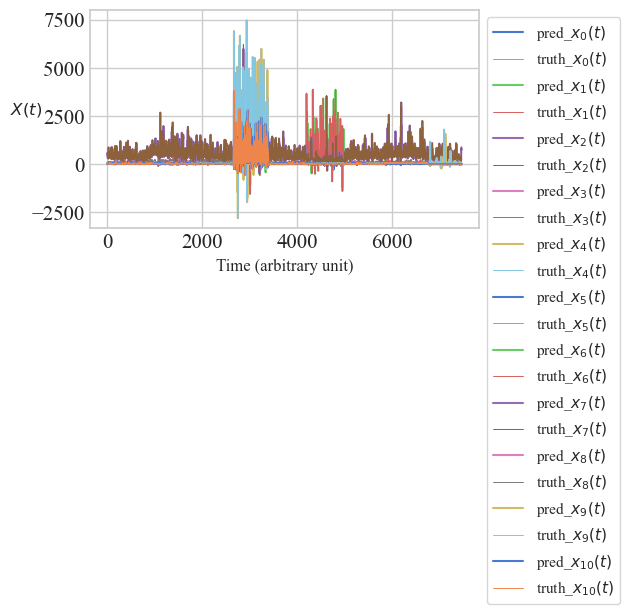

DONE


In [763]:
# Input: Time x coefficient matrix column number (in_features)
# Output: Time x output_dimension
# generator(Input, output_dimension)

Accuracy_dict, Precision_dict, Recall_dict, F1_dict, MyScore_dict, MyScore2_dict = dict(), dict(), dict(), dict(), dict(), dict()
Time_dict = dict()
DTW_dict_dict = dict()
Coeff_result_mean_dict, Coeff_result_std_dict, Coeff_result_probability_dict = dict(), dict(), dict()

num_of_var = len(df_stl_1.columns)
print("num of var:",num_of_var)

train_gen, train_dis, test_gen, test_dis = MakeData(num_of_var)
# class Generator より上で定義
outer_iteration = 10
output_dimension = train_dis.shape[1] # number of variables
which_variable_generate = 0 # x0: 0, x1: 1, x2: 2, ...
Time = train_dis.shape[0]

##### SEM ##########
input_dimension = output_dimension * 3 # coefficient matrix's row
#### ODE (or Nonlinear SEM) ############
# input_dimension = train_gen.shape[1] # coefficient matrix's row

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = torch.nn.Linear(in_features = input_dimension, out_features=output_dimension, bias=False) # output: (noise_frequency * 2) x output_features
        torch.nn.init.uniform_(self.linear1.weight, a=0.5, b=1.0)

    def forward(self, x, output_dimension, input_dimension, which_variable_generate, Time):
        x = self.linear1(x)

        return x

generator = Generator()

tmp = torch.mul(generator.linear1.weight.T.reshape(input_dimension * output_dimension, 1), 
MatrixConstraint(ConditionalLabelGenerator(which_variable_generate, input_dimension, output_dimension)))
    # generator.linear1.weight: 2 x 6  --Transpose--> 6 x 2 --reshape--> 12 x 1
weight_new = torch.nn.Parameter(tmp.reshape(output_dimension, input_dimension)) # tmp 12 x 1 --reshape--> 2 x 6
generator.linear1.weight = weight_new

# print(generator)
# print(generator.linear1.weight.T)

# Sample 
# Time = 10
# tmp1 = torch.randn(Time, input_dimension)
# Affine = generator(tmp1,  output_dimension, input_dimension, which_variable_generate, Time)
# print("NNへの入力シグマ：", tmp1)
# print("NNの出力（データ）：", Affine)
# print("重み（係数）行列（グザイ予測値）: ",generator.linear1.weight.T)
# たしかに、tmp （入力）に、重み num_of_var (output_dimension) x coeff matrix row の転値を行列積すると出力Affineになる。
##############################################################################################################################

lr = 0.01
#     iteration = 1000
iteration = 500 * num_of_var
lambda_notears = 10.0
lambda_regularizer = 0.01
regularization_setting = "baseline" # "baseline", "L1", "L2"
notears_penalty_setting = "with no tears" # "with no tears", "without no tears"

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
Generator_loss = torch.nn.MSELoss()

weight_parameter_coeff_matrix_list = []
which_variable_generate_list = Which_variable_list(iteration, output_dimension)
generator_losses = []
time_sta = time.perf_counter()
coeff_matrix_row_number = train_gen.shape[1]

for outer_iteration_arg in range(outer_iteration):
    for i in range(iteration):
        which_variable_generate = which_variable_generate_list[i]

        generator_optimizer.zero_grad()  

        train_dis_reshaped = train_dis.T.reshape(train_dis.shape[0] * output_dimension, 1)
        train_dis_reshaped = torch.mul(train_dis_reshaped,
                            ConditionalLabelGenerator(which_variable_generate, train_dis.shape[0], output_dimension))

        Affine = generator(train_gen,  output_dimension, input_dimension, which_variable_generate, Time)

        generator_loss = Generator_loss(Affine, train_dis) # 損失を計算(shapeを揃える)

        coeff_matrix = generator.linear1.weight.T

        if regularization_setting == "baseline":
            pass
        elif regularization_setting == "L1":
            generator_loss += lambda_regularizer * torch.linalg.matrix_norm(coeff_matrix, ord=1)        # 損失を計算(shapeを揃える)
        elif regularization_setting == "L2":
            generator_loss += lambda_regularizer * torch.norm(coeff_matrix, p="fro")     # 損失を計算(shapeを揃える)
        else:
            print("Regularization setting expects 'baseline', 'L1', or 'L2' only.")
            break

        mat3 = coeff_matrix[0 : output_dimension]

        if notears_penalty_setting == "with no tears": # "with no tears", "without no tears"
            half_iteration = int(iteration/2)
            if i <= half_iteration:
                pass
            else:
                generator_loss += (lambda_notears + lambda_notears * (i-half_iteration)/half_iteration) * notears(mat3, output_dimension)
        elif notears_penalty_setting == "without no tears":
            pass
        else:
            print("NO TEARS penalty setting expects 'with no tears', 'without no tears' only.")
            break

        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        generator_losses.append(generator_loss.item())  
#         if i % 500 == 0:
#             print(i,"/",iteration)

    weight_parameter_coeff_matrix = generator.linear1.weight.T
    weight_parameter_coeff_matrix_list.append(weight_parameter_coeff_matrix)
    if outer_iteration_arg % 5 == 0:
        print("== outer iteration ==", str(outer_iteration_arg),"/",str(outer_iteration))

time_end = time.perf_counter()
tim = time_end- time_sta
Time_dict["x"+str(num_of_var)] = tim / outer_iteration

# 係数行列の平均値 (biasは１ではない)
tmp = torch.zeros(input_dimension, output_dimension)
for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
    tmp += weight_parameter_coeff_matrix

result_mean = tmp/outer_iteration
Coeff_result_mean_dict["x"+str(num_of_var)] = result_mean

# 係数行列の標準誤差
tmp = torch.zeros(input_dimension, output_dimension)
for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
    var = torch.square(weight_parameter_coeff_matrix - result_mean)
    tmp += var

result_std = torch.sqrt(tmp/(outer_iteration-1))
Coeff_result_std_dict["x"+str(num_of_var)] = result_std

# DTW: Stan Salvador, and Philip Chan. “FastDTW: Toward accurate dynamic time warping in linear time and space.” Intelligent Data Analysis 11.5 (2007): 561-580.

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
plt.rcParams["font.size"] = 10                 # 文字の大きさ
plt.tick_params(labelsize = 15) 
plt.xlabel("Time (arbitrary unit)")
plt.ylabel(r"$X(t)$",rotation=0)

DTW_dict = dict()
for i in range(num_of_var):
    DTW_x0_list = []
    for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
        mat2 = weight_parameter_coeff_matrix

        Affine = generator(test_gen,  output_dimension, input_dimension, which_variable_generate=i, Time=test_gen.shape[0])
        pred_x0 = Affine.data.numpy()[:,i]
        truth_x0 = test_dis.data.numpy()[:,i]

        distance, path = fastdtw(pred_x0.reshape(-1, 1), truth_x0.reshape(-1,1), dist=euclidean)
        DTW_x0_list.append(distance)

    DTW_dict["x"+str(i)+"_mean"] = np.mean(DTW_x0_list)
    DTW_dict["x"+str(i)+"_std"] = np.std(DTW_x0_list)

    # 動的挙動
    width = int(len(pred_x0))
    plt.plot(np.linspace(0,width-1,width),pred_x0[0:width], label=r"pred_$x_{"+str(i)+"}(t)$")
    plt.plot(np.linspace(0,width-1,width),truth_x0[0:width],linewidth=0.7, label=r"truth_$x_{"+str(i)+"}(t)$")

DTW_dict_dict["x"+str(num_of_var)] = DTW_dict
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout() 
plt.savefig("sample_data_"+str(num_of_var)+"_prediction.svg")
plt.savefig("sample_data_"+str(num_of_var)+"_prediction.png")
plt.show()

print("DONE")

In [815]:
# Probability
# 絶対値がthreshold を超えるか判定
thresholding_list = []
threshold = 0.005

for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
    tmp = torch.where(torch.abs(weight_parameter_coeff_matrix) <= threshold, torch.tensor(0.0), torch.ones(weight_parameter_coeff_matrix.shape))
    thresholding_list.append(tmp)

tmp = torch.zeros(input_dimension, output_dimension)
for i in thresholding_list:
    tmp += i

#     coeff_pred = tmp/outer_iteration

# for hh in range(threshold_value_candidate):
#     threshold = torch.min(torch.abs(weight_parameter_coeff_matrix)) + width * hh / threshold_value_candidate # This threshold value is very important
#     thresholding_list = []
#     for weight_parameter_coeff_matrix in weight_parameter_coeff_matrix_list:
#         # torch.where(torch.abs(weight_parameter_coeff_matrix) <= threshold, torch.tensor(0.0), weight_parameter_coeff_matrix)
#         tmp = torch.where(torch.abs(weight_parameter_coeff_matrix) <= threshold, torch.tensor(0.0), torch.ones(weight_parameter_coeff_matrix.shape))
#         thresholding_list.append(tmp)

#     tmp = torch.zeros(input_dimension, output_dimension)
#     for i in thresholding_list:
#         tmp += i

coeff_pred = tmp/outer_iteration;coeff_pred

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
        [1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.,

In [816]:
adj_matrix = coeff_pred[0:num_of_var].data.numpy()
# adj_matrix = coeff_pred[num_of_var:num_of_var*2].data.numpy()

In [817]:
# DTW_dict_dict["x"+str(17)], Time_dict["x"+str(17)]

In [818]:
# DTW_mean_list = DTW_Mean(DTW_dict_list);DTW_mean_list

In [819]:
import networkx as nx

In [820]:
G.clear()
G = nx.DiGraph()
edge_labels = dict()
edgewidth = []
edgecolor = []
# A = pd.DataFrame(adj_matrix)
for i in range(num_of_var):
    for j in range(num_of_var):
        if adj_matrix[i][j] ==1.0:
            G.add_edge(df.columns[i], df.columns[j])
            tmp = round(float(Coeff_result_mean_dict["x"+str(num_of_var)][i][j].data.numpy())*5, 3)
            edgewidth.append(abs(tmp))
            if tmp >=0:
                edgecolor.append("red")
            else:
                edgecolor.append("blue")
            edge_labels[(df.columns[i], df.columns[j])] = round(float(Coeff_result_mean_dict["x"+str(num_of_var)][i][j].data.numpy()), 3)
# G = nx.from_pandas_adjacency(A)

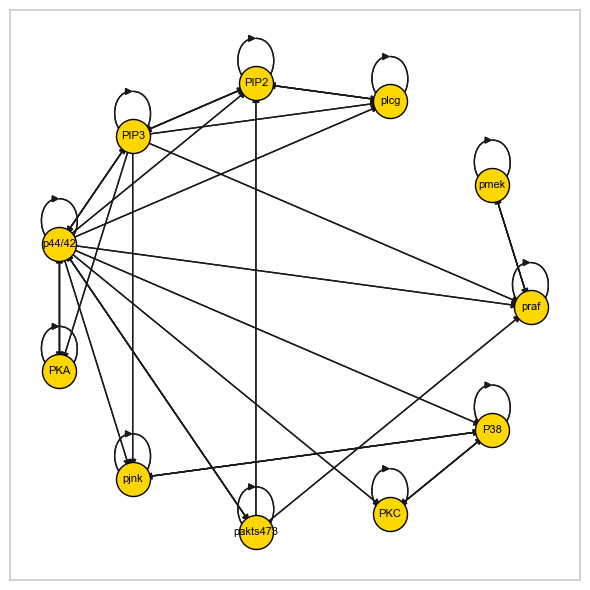

In [821]:
fig, ax = plt.subplots(figsize=(6, 6),tight_layout=True)
ax.grid(False)
pos = nx.circular_layout(G, scale=2) # center=None, dim=2
# pos = nx.spring_layout(G, seed=3113794652)
# pos = hierarchy_pos(G,1)
# nx.draw_networkx(G, pos, font_size=8, font_color="black", with_labels = True, width=3, \
#                  edge_color = edgecolor)
nx.draw_networkx(G, pos, font_size=8, font_color="black", with_labels = True, width=1)
# nx.draw_networkx_nodes(graph, pos, node_size=100, node_color="w")
nx.draw_networkx_edges(G, pos, width = 1) # width = edgewidth
# nx.draw_networkx_edge_labels(G, pos, edge_labels)
nx.draw_networkx_nodes(G, pos, edgecolors = "black", node_color='gold', node_size=600)

# nx.draw_networkx_labels(graph, pos, font_size=16, font_color="r")
# plt.savefig("sachs.svg")
# plt.savefig("sachs.png")
plt.show()

In [481]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)